In [1]:
import os
import warnings

import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import segmentation_models_pytorch as smp

import SimpleITK as sitk
import torch

from alive_progress import alive_bar

from torch.utils.data import DataLoader, TensorDataset
import segmentation_models_pytorch.utils.metrics

warnings.filterwarnings("ignore")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:200"

/home/cm506/Project/torch_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def scale(slice):                                                               ## Defines function to window, level, and normalise pixel values
    min = -160                                                                  
    max = 240
    slice[slice < min] = min                                                    ## Masks values above or below the max/min
    slice[slice > max] = max
    slice = (slice - min) / (max - min)                                         ## Scales between 0-1
    new_slice = np.array(slice)                                                 ## Converts to numpy
    return new_slice                                                            ## Returns the scaled slice

def to_rgb(slice):
    rgb = cv2.cvtColor(slice, cv2.COLOR_GRAY2RGB)
    return rgb

def load_image(start, end, CT=None, SEG=None):                                  ## Takes inputs of number of patients we want, and CT or SEG = True for if we want CT or SEG
    assert not (CT is None and SEG is None)                                     ## Checks that we have actually inputted either CT=True or SEG=True
    assert CT or SEG                                                            ## Checks again that we have selected one or the other
    assert not (CT and SEG)                                                     ## Checks that we havent selected both

    if CT:                                                                      ## If CT is selected
        test_scaled = []
        test_raw = []                                                           
        for filename in sorted(os.listdir('./data/test/'))[start:end]:          ## Loop through sorted files in the test folder up to the chosen patient value
            data = sitk.ReadImage(f'./data/test/{filename}')                    ## Reads the CT file with the number and .nii suffix
            array = sitk.GetArrayFromImage(data)                                ## Gets the image array from the patient sitk object
            for slice in array:                                                 ## Loops through each slice in the 3D volume
                test_raw.append(slice)                                          ## Appends the raw file for visualisation
                slice = np.float32(slice)                                       ## Converts slice to float 32 (error makes it necessary for the to_rgb() function)     
                test_scaled.append(np.array(to_rgb(np.float32(scale(slice)))))  ## Runs the scale -> to_rgb() -> to np array -> and appends to the test list
        test_scaled = np.array(test_scaled)                                     ## Converts list to np array                                                
        print(f'Scaled files: {len(test_scaled)}, Min: {test_scaled.min()}, Max: {test_scaled.max()}.') ## Prints stats - Should have a min and max of 0 - 1
        return test_raw, test_scaled                                            ## Returns the raw files and scaled files
        
    elif SEG:                                                                   ## Repeats the same but for the segmentation images
        test_labels_raw = []
        for filename in sorted(os.listdir('./data/test_labels/'))[start:end]:
            data = sitk.ReadImage(f'./data/test_labels/{filename}')
            array = sitk.GetArrayFromImage(data)
            for slice in array:
                test_labels_raw.append(np.array(slice))
        test_labels_raw = np.array(test_labels_raw)
        print(len(test_labels_raw))
        return test_labels_raw

In [7]:
start = 15 ## Start and end denote the tetsing patient files we want to extract
end = 18

In [4]:
test_raw, test = load_image(start, end, CT=True) ## Extracts the raw CT file, and the scaled CT file into two varables. Used for plotting

Scaled files: 2590, Min: 0.0, Max: 1.0.


In [8]:
test_labels = load_image(start, end, SEG=True) ## Extracts the testing segmentation for validation

2590


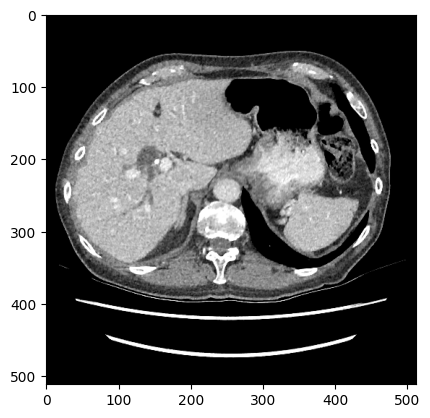

In [6]:
plt.imshow(test[500], cmap='gray') ## Plots the test image 500

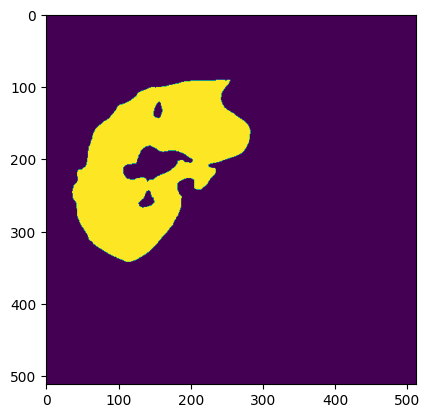

In [7]:
plt.imshow(test_labels[500]) ## Plots test segmentation 500

In [8]:
n_classes = 3 ## Creates n classes (we have background = 0, liver = 1, and tumout = 2 - so three classes)

print('Converting masks to One-hot. This may take a while (~30s)')

from keras.utils import to_categorical ## Imports the to_categorical function from keras. This creates one-hot encoded channles for each class i.e tumour = 0,0,1
test_hot = to_categorical(test_labels, num_classes=n_classes) ## Runs the one-hot on the train data

Converting masks to One-hot. This may take a while (~30s)


2023-08-07 18:59:42.231210: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 18:59:43.167322: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [9]:
print(test_hot.shape)

(2590, 512, 512, 3)


In [10]:
print('Reshaping Data')

test_hot = np.transpose(test_hot, (0, 2, 3, 1)) ## Transposes the segmentation data shape from N,H,W,C to N,C,H,W as used in Tensors
test_hot = np.transpose(test_hot, (0, 2, 3, 1)) ## Have to do this twice for some reason

print(test_hot.shape)

Reshaping Data
(2590, 3, 512, 512)


In [11]:
test = np.transpose(test, (0, 2, 3, 1)) ## Reshapes the testing data to N,C,H,W
test = np.transpose(test, (0, 2, 3, 1))

print(test.shape)

(2590, 3, 512, 512)


In [12]:
x_test = torch.as_tensor(test) ## Converts both data and segmentation to tensors
y_test = torch.as_tensor(test_hot)

In [13]:
del test_hot ## Deletes unused variables

In [14]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights ## Imports a FCN ResNet50 model and weights. Mainly used for the preprocessing.

## ResNet50
preprocess_img = FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1.transforms(resize_size=None) ## Creates preprocessing function for the slice data.

# ### Creating DataSet and DataLoader

print('Processing Data. Noramlising to ImageNet weights')

Processing Data. Noramlising to ImageNet weights


In [15]:
x_test = preprocess_img(x_test) ## Preprocesses testing data using ResNet50 weights

In [16]:
test_set = TensorDataset(x_test,y_test) ## Creates a dataset using the training data and trainnin segmentations
test_dataloader = DataLoader(test_set, batch_size=1, pin_memory=True) ## Creates a dataloader from the dataset. No transformations needed as we have already done this

# Importing Models

In [17]:
resnet50 = torch.load('./models/ResNet50_n5_e30.pth', map_location=DEVICE) ## Loads each trained model for testing
resnet101 = torch.load('./models/ResNet101_n5_e30.pth', map_location=DEVICE)
vgg19 = torch.load('./models/vgg19_n5_e30.pth', map_location=DEVICE)

In [18]:
loss = smp.utils.losses.DiceLoss() ## Defines loss function and metrics as Dice Loss and IoU
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

## Resnet50

In [19]:
## Creates the testing Epoch. Basically a validation epoch which loads the testing data

test_resnet50 = smp.utils.train.ValidEpoch( 
    model=resnet50,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

## Logs the IoU and Dice Loss score 

RN50_test_logs = test_resnet50.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {RN50_test_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {RN50_test_logs['dice_loss']:.4f}")

valid: 100%|██████████| 2590/2590 [01:06<00:00, 38.96it/s, dice_loss - 0.006325, iou_score - 0.9879]
Evaluation on Test Data: 
Mean IoU Score: 0.9879
Mean Dice Loss: 0.0063


## ResNet101

In [20]:
## Repeats for ResNet101

test_resnet101 = smp.utils.train.ValidEpoch(
    model=resnet101,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

RN101_test_logs = test_resnet101.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {RN101_test_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {RN101_test_logs['dice_loss']:.4f}")

valid: 100%|██████████| 2590/2590 [01:18<00:00, 33.03it/s, dice_loss - 0.006578, iou_score - 0.9874]
Evaluation on Test Data: 
Mean IoU Score: 0.9874
Mean Dice Loss: 0.0066


## VGG19

In [21]:
## Repeats for VGG19

test_vgg19 = smp.utils.train.ValidEpoch(
    model=vgg19,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

vgg_test_logs = test_vgg19.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {vgg_test_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {vgg_test_logs['dice_loss']:.4f}")

valid: 100%|██████████| 2590/2590 [01:40<00:00, 25.74it/s, dice_loss - 0.02047, iou_score - 0.9665]
Evaluation on Test Data: 
Mean IoU Score: 0.9665
Mean Dice Loss: 0.0205


In [22]:
## Converts testing logs to PD Dataframes

RN50_df = pd.DataFrame([RN50_test_logs])
RN101_df = pd.DataFrame([RN101_test_logs])
VGG19_df = pd.DataFrame([vgg_test_logs])

In [23]:
## Exports dataframe to CSV for storage and plotting later.

RN50_df.to_csv(r'./RN50_test_15_18.csv', sep='\t', encoding='utf-8', header='true')
RN101_df.to_csv(r'./RN101_test_15_18.csv', sep='\t', encoding='utf-8', header='true')
VGG19_df.to_csv(r'./VGG19_test_15_18.csv', sep='\t', encoding='utf-8', header='true')

# Run Once models have been Tested on three different datasets for each model

Use; 

- Test 1: 0-3
- Test 2: 7-10
- Test 3: 15-18 

and save CSVs as the following for the same results

- model_stats/RN50_test_0_3.csv
- model_stats/RN50_test_7_10.csv
- model_stats/RN50_test_15_18.csv

- model_stats/RN101_test_0_3.csv
- model_stats/RN101_test_7_10.csv
- model_stats/RN101_test_15_18.csv

- model_stats/VGG19_test_0_3.csv
- model_stats/VGG19_test_7_10.csv
- model_stats/VGG19_test_15_18.csv

In [32]:
## Loads each CSV for each Testing dataset for each model

RN50_1 = pd.read_csv('./model_stats/RN50_test_0_3.csv', sep='\t', encoding='utf-8')
RN50_2 = pd.read_csv('./model_stats/RN50_test_7_10.csv', sep='\t', encoding='utf-8')
RN50_3 = pd.read_csv('./model_stats/RN50_test_15_18.csv', sep='\t', encoding='utf-8')

RN101_1 = pd.read_csv('./model_stats/RN101_test_0_3.csv', sep='\t', encoding='utf-8')
RN101_2 = pd.read_csv('./model_stats/RN101_test_7_10.csv', sep='\t', encoding='utf-8')
RN101_3 = pd.read_csv('./model_stats/RN101_test_15_18.csv', sep='\t', encoding='utf-8')

VGG_1 = pd.read_csv('./model_stats/VGG19_test_0_3.csv', sep='\t', encoding='utf-8')
VGG_2 = pd.read_csv('./model_stats/VGG19_test_7_10.csv', sep='\t', encoding='utf-8')
VGG_3 = pd.read_csv('./model_stats/VGG19_test_15_18.csv', sep='\t', encoding='utf-8')

In [34]:
## Creates tist for plotting each models metrics

RN50_frames = [RN50_1, RN50_2, RN50_3]
RN101_frames = [RN101_1, RN101_2, RN101_3]
VGG_frames = [VGG_1, VGG_2, VGG_3]

In [35]:
## Concatenates each model metrics into one dataframe for each

RN50_stats = pd.concat(RN50_frames)
RN101_stats = pd.concat(RN101_frames)
VGG_stats = pd.concat(VGG_frames)

In [2]:
## Defines the IoU Barplot. Effectively makes a dictionary of 3 objects with all 9 tests in order. Allows to plot a bar for each within each model.

IoU_barplot = pd.DataFrame({'Model': ['ResNet50', 'ResNet101', 'VGG-19','ResNet50', 'ResNet101', 'VGG-19','ResNet50', 'ResNet101', 'VGG-19'], 'IoU': [0.977065, 0.975471, 0.938722, 0.987427, 0.984994, 0.967357, 0.987850, 0.987421, 0.966454], 'Data': ['0-3', '0-3', '0-3', '7-10', '7-10', '7-10', '15-18', '15-18', '15-18']})

In [3]:
## Repeats using the Dice metrics. This could be automated extracting data fromt a dictionary but I'm not repeating it so I dont need to.

Dice_barplot = pd.DataFrame({'Model': ['ResNet50', 'ResNet101', 'VGG-19','ResNet50', 'ResNet101', 'VGG-19','ResNet50', 'ResNet101', 'VGG-19'], 'DICE': [0.012014, 0.012895, 0.036482, 0.006595, 0.007902, 0.019789, 0.006325, 0.006578, 0.020467], 'Data': ['0-3', '0-3', '0-3', '7-10', '7-10', '7-10', '15-18', '15-18', '15-18']})

In [4]:
## Sets colours for the seaborn plot. Not the best for colourbling but they have hashes.

colors = ["#69b3a2", "#4374B3", "#7A9E7E"]
sns.set_palette(sns.color_palette(colors))

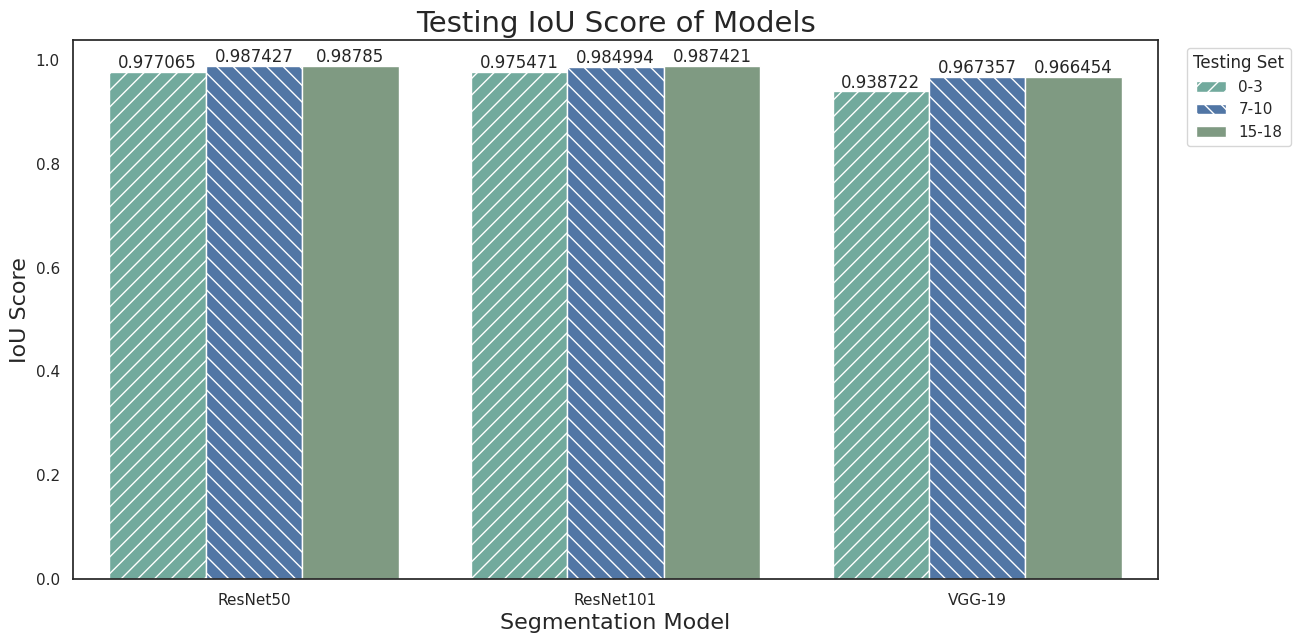

In [10]:
## Defines seaborn plots

sns.set(style="white") ## Sets background to white
sns.set_palette(sns.color_palette(colors)) ## Sets pallette to the coulours

plt.figure(figsize=(14, 7)) ## Creates plot size
ax = sns.barplot(x='Model', y='IoU', hue='Data', data=IoU_barplot) ## Uses matplotlib subplots to plot the seaborn bar chart
ax.set_title("Testing IoU Score of Models", fontsize=21)
ax.set_ylabel("IoU Score", fontsize=16)
ax.set_xlabel("Segmentation Model", fontsize=16)
for i in ax.containers: ## Loops through each bar 
    ax.bar_label(i,) ## Adds the value to the top of the bar label
hatches = ["//", "\\\\", ""] ## Creates a list of hashes used to overlay on the bars
for bars, hatch in zip(ax.containers, hatches): ## Loops through each bar and hash
    for bar in bars: ## For the first bar in each set of bars;
        bar.set_hatch(hatch) ## Add the corresponding hash in the hashes list
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title='Testing Set') ## Add legend outside of the plot using the colours and hashes
plt.savefig('./Images/Testing_IoU_barplot.png') ## Save the plot

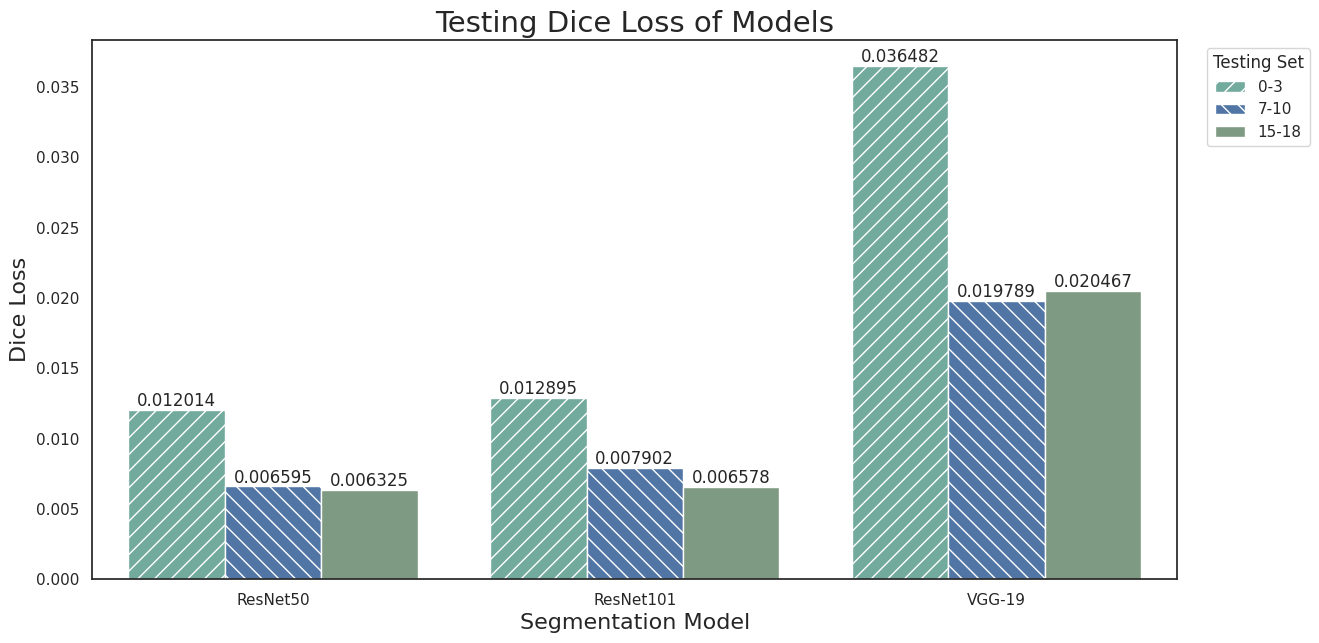

In [11]:
## Repeats the above for the dice plot

plt.figure(figsize=(14, 7))
ax = sns.barplot(x='Model', y='DICE', hue='Data', data=Dice_barplot) 
ax.set_title("Testing Dice Loss of Models", fontsize=21)
ax.set_ylabel("Dice Loss", fontsize=16)
ax.set_xlabel("Segmentation Model", fontsize=16)
for i in ax.containers:
    ax.bar_label(i,)
hatches = ["//", "\\\\", ""]
for bars, hatch in zip(ax.containers, hatches):
    for bar in bars:
        bar.set_hatch(hatch)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title='Testing Set')
plt.savefig('./Images/Testing_Dice_barplot.png')

## Visualising Predictions

In [24]:
## Defines plot to show image pipeline and predictions

def plotting_pred(num):
    x_tensor = x_test[num].to(DEVICE).unsqueeze(0) ## Takes the tensor from x_test index i, unsqueezes into a 1D vector and sends to the GPU
    
    res50_pred_mask = resnet50(x_tensor) ## Runs the corresponding model on the image vector
    res101_pred_mask = resnet101(x_tensor)
    vgg_pred_mask = vgg19(x_tensor) 

    res50_pred_mask = res50_pred_mask.detach().squeeze().cpu().numpy() ## Returns the output to the CPU, converts back to three channel segmentation, converts to numpy
    res101_pred_mask = res101_pred_mask.detach().squeeze().cpu().numpy()
    vgg_pred_mask = vgg_pred_mask.detach().squeeze().cpu().numpy()  

    res50_pred_mask = np.transpose(res50_pred_mask,(1,2,0)) ## Reshapes data to 512,512,3
    res101_pred_mask = np.transpose(res101_pred_mask,(1,2,0))
    vgg_pred_mask = np.transpose(vgg_pred_mask,(1,2,0))

    data = np.transpose(test[num], (2,0,1)) ## Reshapes original raw image
    data = np.transpose(data, (2,0,1)) ## Need to do this twice. I messed up the transpose indexes.

    fig, axs = plt.subplots(2, 3) ## Creates 2x3 subplots
    axs[0, 0].imshow(test_raw[num], cmap='gray') ## Plots raw image
    axs[0, 0].set_title(f'Raw')
    axs[0, 0].axis('off')
    
    axs[0, 1].imshow(data, cmap='gray') ## Plots processed image
    axs[0, 1].set_title(f'Preprocessed')
    axs[0, 1].axis('off')

    axs[0, 2].imshow(test_labels[num]) ## Plots ground truth segmentation
    axs[0, 2].set_title(f'Manual Segmentation')
    axs[0, 2].axis('off')
    
    axs[1, 0].imshow(res50_pred_mask, cmap='gray') ## Plots ResNet50 Segmentation
    axs[1, 0].set_title(f'ResNet50 Pred')
    axs[1, 0].axis('off')
    
    axs[1, 1].imshow(res101_pred_mask, cmap='gray') ## Plots ResNet101 Segmentation
    axs[1, 1].set_title(f'ResNet101 Pred')
    axs[1, 1].axis('off')
    
    axs[1, 2].imshow(vgg_pred_mask, cmap='gray') ## Plots VGG19 Segmentation
    axs[1, 2].set_title(f'VGG19 Pred')
    axs[1, 2].axis('off')

    fig.suptitle(f'Image {num} Pipeline and Model Predictions', fontsize=21) ## Plots title

    ## fig.savefig(f'Image {num} pipeline and model predictions')  ## Uncomment if you want to save the figs

In [25]:
plotting_pred(425)